# calculate (Basset) History term
In this  notebook the (basset) history force is calculated given by: 
$$ \mathbf{F}_{history}  = 3\pi \nu_f d \int_{0}^t K(t-s)\frac{d}{ds} (\mathbf{u}_p(s) -\mathbf{u}_s(s)) ds $$ 
with the ``Kernel'' K depends on the particle Reynolds number, for small Reynolds number we have the Basset version:
$$ K_{Basset} = \frac{d}{2 \pi \sqrt{t-s}}$$
For larger particle Reynolds number different history kernels are used (there is no concensus on the exact form),
 however the Basset history term can be used as an upper limit as it overestimates the size of the history term for 
 larger particle Reynolds numbers

In [1]:
# import needed packages

import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
from datetime import datetime, timedelta
import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
plt.style.use('../python_style_Meike.mplstyle')

Rearth = 6371 * 10**3 # in k,
deg2rad = np.pi / 180.
sec_in_min = 60
min_in_hour = 60
sec_in_hour = sec_in_min * min_in_hour

In [160]:
# define functions for calculating history force
def stokes_relaxation_time(d, viscosity_water, B):
    return (1 + 2 * B) * d * d / (36 * viscosity_water)
 
def Basset_kernel(t,s,d, nu):
    tau_diff = d * d / nu
    return (tau_diff / (4 * np.pi * (t-s)))**(0.5)

def Mei1992_kernel(t,s,c1,c2,d, nu, Rep):
    tau_diff = d * d / nu
    term1 = (4 * np.pi * (t-s) /tau_diff)**(1./(2 * c1))
    fh = (0.75 + c2 * Rep)**3
    term2 =  (Rep**3 * np.pi * (t-s)**2 / (fh * tau_diff**2) )**(1./c1) 
    return (term1+term2)**(-c1)

def dUslip_dt(uslip,dt):
        umin=uslip.shift(obs=-1)
        umax=uslip.shift(obs=1)
        return (uslip-umin)/(1 * dt)

def REp(uslip,vslip, d, nu):
    return np.sqrt(uslip**2 + vslip**2) * d / nu

def factor_drag(Uslip,L,nu):
    Rep=np.abs(Uslip) * L / nu
    f_REp = 1 + Rep / (4. * (1 +  np.sqrt(Rep))) + Rep / 60.
    return f_REp


# constants
rho_water = 1027 # kg/m3 https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
dynamic_viscosity_water = 1.41 * 10**(-3) # kg/(ms) https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
kinematic_viscosity_water = dynamic_viscosity_water / rho_water
diameter =0.2 # m
B=0.68
tau_p = stokes_relaxation_time(diameter, kinematic_viscosity_water, B)


cs = {'Mei':{'c1':2,'c2':0.105},
             'Kim':{'c1':2.5,'c2':0.126},
             'Dorgan':{'c1':2.5,'c2':0.2}}

# calculate basset history term for high time resolution data
We use data that ran for 24 h with output every 5 min to calculate
the basset history kernel and term and invastigate its sensitivity
to total timewindow and timesteps used. 

In [8]:
#import short high resolution data
particle_types = ['inertial','inertial_SM','inertial_drag_REp','inertial_SM_drag_REp']
legendnames=['MR Stokes drag','MRSM Stokes drag','MR Re$_p$ drag','MRSM Re$_p$ drag']

file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_slip_velocity.zarr')

data_24h ={}

#settings
runtime =  timedelta(days=1)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 2, 0, 0, 0, 0)
endtime = starttime + runtime

chunck_time = 100
nparticles = 88347

for particle_type in particle_types: 
    file = file_base.format(loc=loc,
                           particle_type = particle_type,
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling, 
                                                            cor_on = coriolis)
    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    data_24h[particle_type]=ds
    

In [62]:
particle_types = ['inertial','inertial_SM','inertial_drag_REp','inertial_SM_drag_REp']
legendnames=['MR Stokes drag','MRSM Stokes drag','MR Re$_p$ drag','MRSM Re$_p$ drag']

file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_slip_velocity.zarr')

data_month ={}

#settings
runtime =  timedelta(days=30)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 2, 0, 0, 0, 0)
endtime = starttime + runtime

chunck_time = 100
nparticles = 88347

for particle_type in particle_types: 
    file = file_base.format(loc=loc,
                           particle_type = particle_type,
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling, 
                                                            cor_on = coriolis)
    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    data_month[particle_type]=ds
    

In [161]:
for particle_type in particle_types:

    dt = (data_24h[particle_type].time[0,1] -data_24h[particle_type].time[0,0]).values
    print(dt)

    duslipdt = dUslip_dt(data_24h[particle_type].uf,dt)
    dvslipdt = dUslip_dt(data_24h[particle_type].vf,dt)    
    data_24h[particle_type] = data_24h[particle_type].assign(duslipdt = duslipdt)
    data_24h[particle_type] = data_24h[particle_type].assign(dvslipdt = dvslipdt)


300.0
300.0
300.0
300.0


In [162]:
for particle_type in particle_types:

    dt = (data_month[particle_type].time[0,1] -data_month[particle_type].time[0,0]).values
    print(dt)

    duslipdt = dUslip_dt(data_month[particle_type].uf,dt)
    dvslipdt = dUslip_dt(data_month[particle_type].vf,dt)    
    data_month[particle_type] = data_month[particle_type].assign(duslipdt = duslipdt)
    data_month[particle_type] = data_month[particle_type].assign(dvslipdt = dvslipdt)

3600.0
3600.0
3600.0
3600.0


In [248]:
ds_compare = xr.open_dataset('/storage/shared/oceanparcels/output_data/data_Meike/MR_advection/NWES/inertial_drag_REp/NWES_start2023_09_02_end2023_09_03_RK4_B0680_tau2759_anti_beaching_cor_True_slip_velocity_v2.zarr',                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
Uslip = np.sqrt(ds_compare.uf **2 + ds_compare.vf**2) 
ds_compare = ds_compare.assign(Uslip = Uslip)

duslipdt = dUslip_dt(ds_compare.uf,dt)
dvslipdt = dUslip_dt(ds_compare.vf,dt)    
ds_compare = ds_compare.assign(duslipdt = duslipdt)
ds_compare = ds_compare.assign(dvslipdt = dvslipdt)

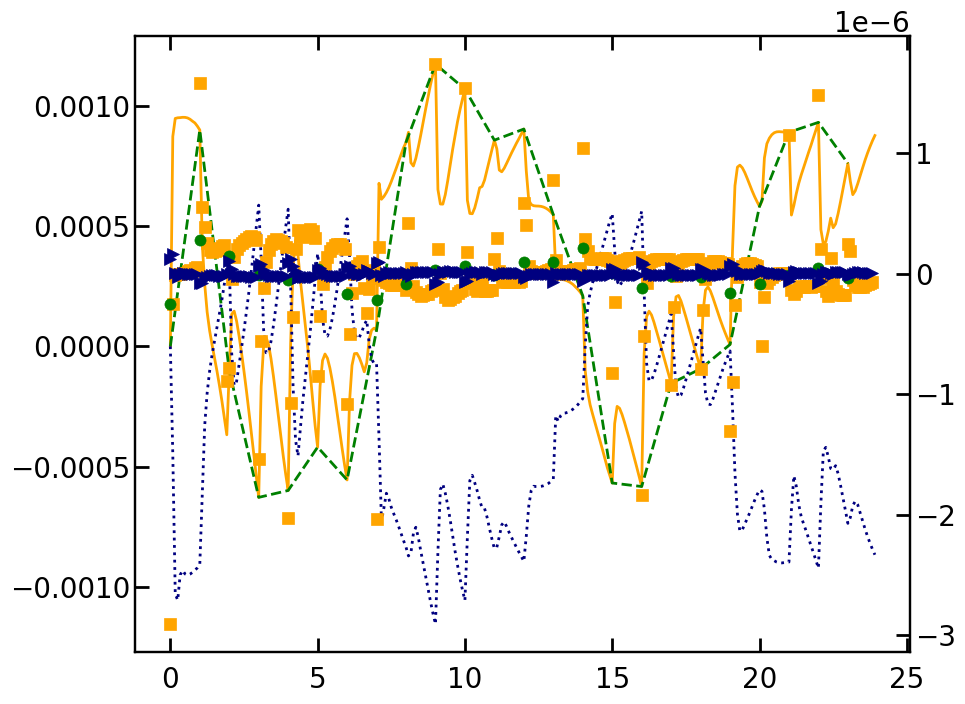

In [223]:
particle_type = 'inertial_drag_REp'
id = 1
fig, ax = plt.subplots()
ax.plot((data_24h[particle_type].time[id,:]-data_24h[particle_type].time[id,0])/sec_in_hour,data_24h[particle_type].uf[id,:],'-',color='orange')
ax2 = ax.twinx()
ax2.plot((data_24h[particle_type].time[id,:]-data_24h[particle_type].time[id,0])/sec_in_hour,data_24h[particle_type].duslipdt[id,:],'s',color='orange')
#very spikey data? 

# particle_type = 'inertial_SM_drag_REp'
# ax.plot(data_24h[particle_type].time[id,5::12]-data_24h[particle_type].time[id,0],data_24h[particle_type].duslipdt[id,5::12])
ax.plot((data_month[particle_type].time[id,:24]-data_month[particle_type].time[id,0])/sec_in_hour,data_month[particle_type].uf[id,0:24],'--',color='green')

ax2.plot((data_month[particle_type].time[id,:24]-data_month[particle_type].time[id,0])/sec_in_hour,data_month[particle_type].duslipdt[id,0:24],'o',color='green')

ax.plot((ds_compare.time[id,:]-ds_compare.time[id,0])/sec_in_hour,ds_compare.uf[id,0:],':',color='navy')

ax2.plot((ds_compare.time[id,:]-ds_compare.time[id,0])/sec_in_hour,ds_compare.duslipdt[id,],'>',color='navy')


[]

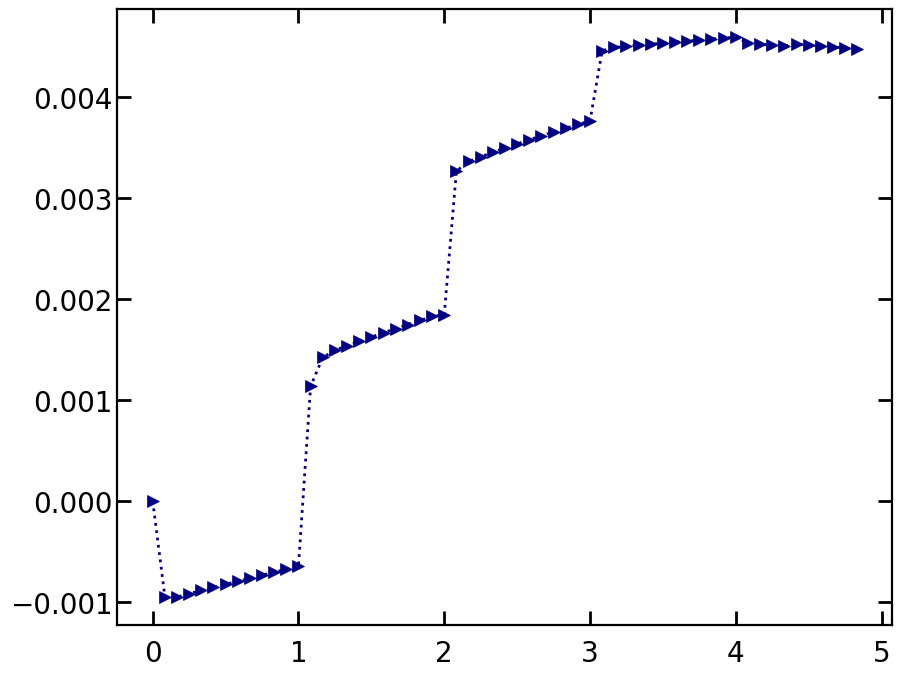

In [249]:
fig, ax = plt.subplots()
id=1
ax.plot((ds_compare.time[id,:]-ds_compare.time[id,0])/sec_in_hour,ds_compare.vf[id,],':>',color='navy')
ax2.plot()

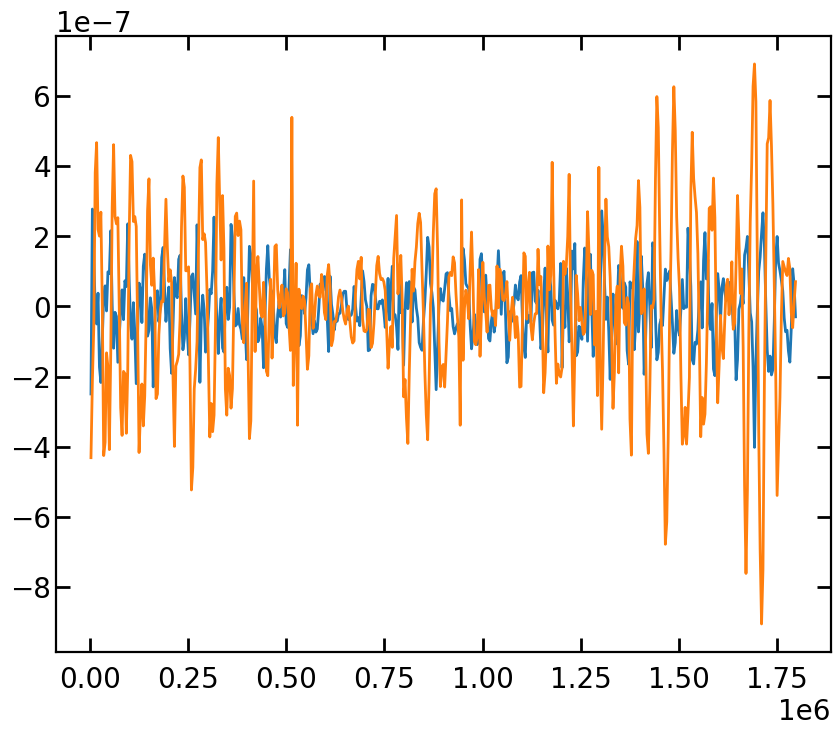

In [154]:
particle_type = 'inertial_drag_REp'
id = 1
fig, ax = plt.subplots()
ax.plot(data_month[particle_type].time[id,:500]-data_month[particle_type].time[id,0],data_month[particle_type].duslipdt[id,:500])
particle_type = 'inertial_SM_drag_REp'
ax.plot(data_month[particle_type].time[id,:500]-data_month[particle_type].time[id,0],data_month[particle_type].duslipdt[id,:500])

300.0


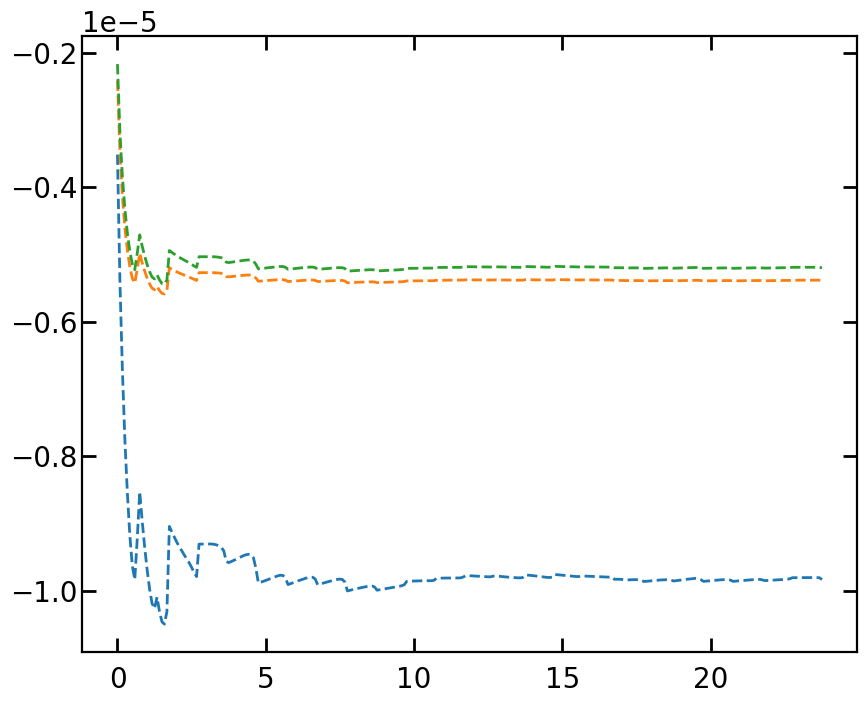

In [157]:
# calculate history term as function of starting time (t0)
id = 1
particle_type = 'inertial_drag_REp'
Tend=24*12-1
dt = (data_24h[particle_type].time[id,1]-data_24h[particle_type].time[id,0]).values
print(dt)
slist = data_24h[particle_type].time[id,1:Tend]
KBasset = Basset_kernel(data_24h[particle_type].time[id,Tend],slist,nu=kinematic_viscosity_water, d= diameter).values
KDorgan = Mei1992_kernel(data_24h[particle_type].time[id,Tend],slist,cs['Dorgan']['c1'],cs['Dorgan']['c2'],diameter, kinematic_viscosity_water,Rep=300)#0.001)
KMei = Mei1992_kernel(data_24h[particle_type].time[id,Tend],slist,cs['Mei']['c1'],cs['Mei']['c2'],diameter, kinematic_viscosity_water,Rep=300)#0.001)
KKim = Mei1992_kernel(data_24h[particle_type].time[id,Tend],slist,cs['Kim']['c1'],cs['Kim']['c2'],diameter, kinematic_viscosity_water,Rep=300)#0.001)

integral_Kim = np.flip(KKim*data_24h[particle_type].duslipdt[id,1:Tend].values )* dt
integral_Basset = np.flip(KBasset*data_24h[particle_type].duslipdt[id,1:Tend].values )* dt
integral_Dorgan = np.flip(KDorgan*data_24h[particle_type].duslipdt[id,1:Tend].values )* dt
integral_Mei = np.flip(KMei*data_24h[particle_type].duslipdt[id,1:Tend].values )* dt
fig,ax=plt.subplots()
# ax.plot((slist-slist[0])/sec_in_hour,np.flip(Bkernel),'--',color='grey')
# ax.plot((slist-slist[0])/sec_in_hour,integral_Basset,'-s')
C_Rep = factor_drag(data_24h[particle_type].Uslip[id,Tend], diameter, kinematic_viscosity_water).values
ax.plot((slist-slist[0])/sec_in_hour,1/C_Rep *np.cumsum(integral_Dorgan),'--')
ax.plot((slist-slist[0])/sec_in_hour,1/C_Rep *np.cumsum(integral_Mei),'--')
ax.plot((slist-slist[0])/sec_in_hour,1/C_Rep *np.cumsum(integral_Kim),'--')

# ax.plot((slist-slist[0])/sec_in_hour,1/C_Rep *  np.cumsum(integral_Basset) /data_24h[particle_type].Uslip[id,Tend].values,'--')

# ax.plot((slist-slist[0])/sec_in_hour,np.cumsum(integral_Basset),'--o')
# ax2 = ax.twinx()
# ax.plot((slist-slist[0])/sec_in_hour,data_24h[particle_type].uf[id,1:Tend].values)
# ax2 = ax.twinx()
# ax2.plot((slist-slist[0])/sec_in_hour,data_24h[particle_type].duslipdt[id,1:Tend].values,'--o')
# ax.axhline(data_24h[particle_type].uf[id,Tend-1],color='black',zorder=-10)

(0.0, 96.0)

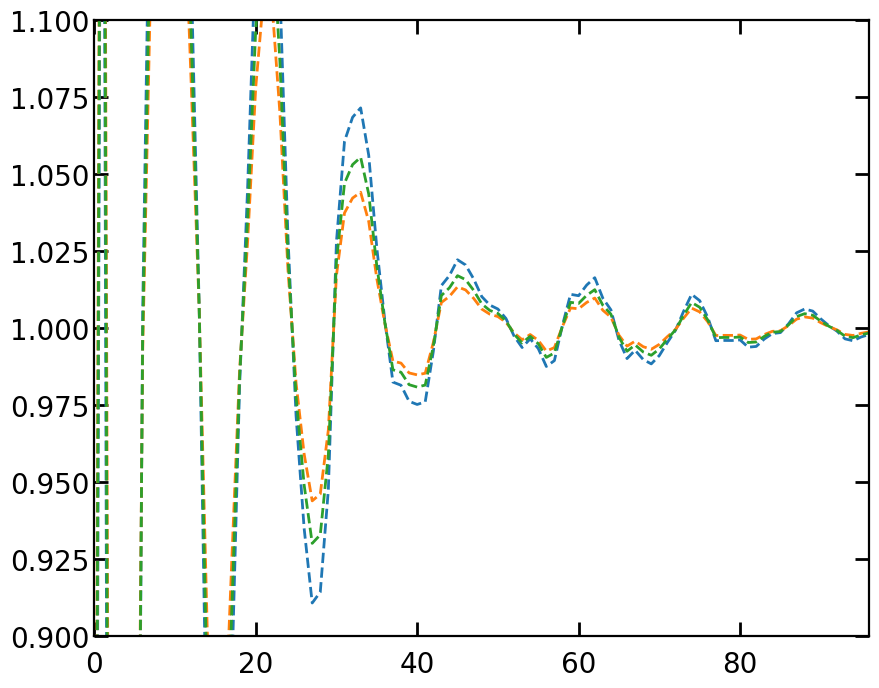

In [208]:
# calculate history term as function of starting time (t0)
id = 1
particle_type = 'inertial_drag_REp'
Tend=500
dt = 3600#(data_month[particle_type].time[id,1]-data_month[particle_type].time[id,0]).values
slist = data_month[particle_type].time[id,1:Tend]
KBasset = Basset_kernel(data_month[particle_type].time[id,Tend],slist,nu=kinematic_viscosity_water, d= diameter).values
KDorgan = Mei1992_kernel(data_month[particle_type].time[id,Tend],slist,cs['Dorgan']['c1'],cs['Dorgan']['c2'],diameter, kinematic_viscosity_water,Rep=300)#0.001)
KMei = Mei1992_kernel(data_month[particle_type].time[id,Tend],slist,cs['Mei']['c1'],cs['Mei']['c2'],diameter, kinematic_viscosity_water,Rep=300)#0.001)
KKim = Mei1992_kernel(data_month[particle_type].time[id,Tend],slist,cs['Kim']['c1'],cs['Kim']['c2'],diameter, kinematic_viscosity_water,Rep=300)#0.001)

integral_Kim = np.flip(KKim*data_month[particle_type].duslipdt[id,1:Tend].values )* dt
integral_Basset = np.flip(KBasset*data_month[particle_type].duslipdt[id,1:Tend].values )* dt
integral_Dorgan = np.flip(KDorgan*data_month[particle_type].duslipdt[id,1:Tend].values )* dt
integral_Mei = np.flip(KMei*data_month[particle_type].duslipdt[id,1:Tend].values )* dt

fig,ax=plt.subplots()

ax.plot((slist-slist[0])/sec_in_hour,np.cumsum(integral_Dorgan)/(np.cumsum(integral_Dorgan)[480]),'--')
ax.plot((slist-slist[0])/sec_in_hour,np.cumsum(integral_Mei)/(np.cumsum(integral_Mei)[480]),'--')
ax.plot((slist-slist[0])/sec_in_hour,np.cumsum(integral_Kim)/(np.cumsum(integral_Kim)[480]),'--')
ax.set_ylim(0.9,1.1)
ax.set_xlim(0,96)

#we use 96h as integration time (way to big I think)


In [47]:
np.cumsum(np.array([1,2,2,3,1,5]))

array([ 1,  3,  5,  8,  9, 14])

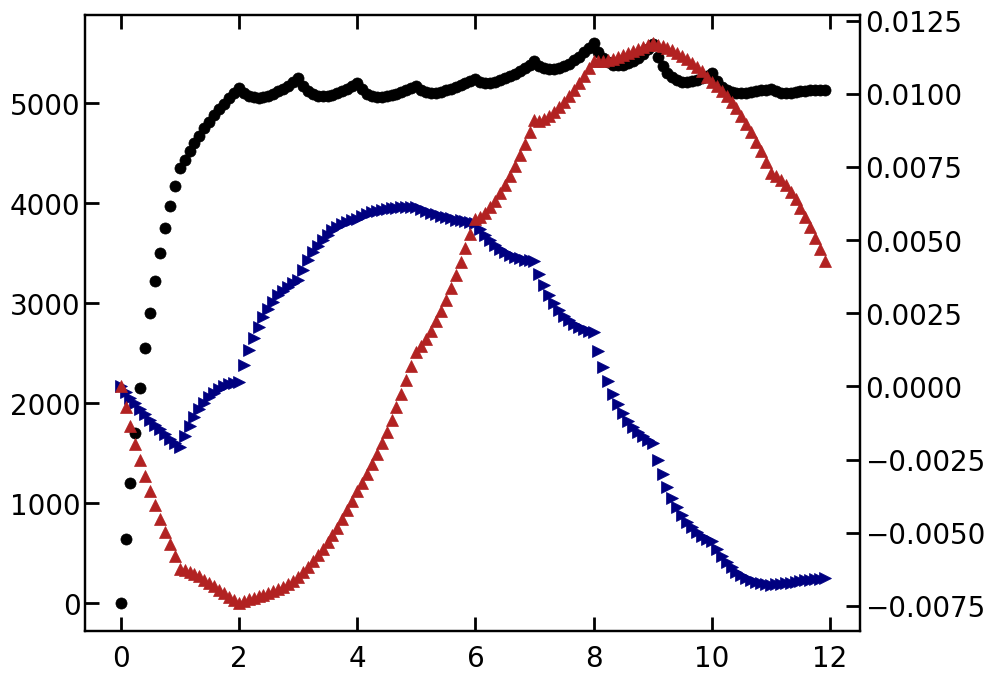

In [39]:
uslip =ds.uf.where(np.abs(ds['uf']) < 1.) 
vslip =  ds.vf.where(np.abs(ds['vf']) < 1.) 
REPs = REp(uslip,vslip,diameter, kinematic_viscosity_water)
mean = REPs.mean(dim='trajectory',skipna=True)
 
fig,ax=plt.subplots()
ax.plot((ds.time[0]-ds.time[0,0])/sec_in_hour,mean[:],'o',color='k')
ax2= ax.twinx()
ax2.plot((ds.time[0]-ds.time[0,0])/sec_in_hour,ds.uf.mean(dim='trajectory',skipna=True),'>',color='navy')
ax2.plot((ds.time[0]-ds.time[0,0])/sec_in_hour,ds.vf.mean(dim='trajectory',skipna=True),'^',color='firebrick')
# ax.plot(ds.Rep.mean(dim='trajectory',skipna=True),'^',color='firebrick')
# ax.set_ylim(0,500)
# ax2.set_ylim(-0.01,0.01)
# print(mean.values
# .size)

In [32]:
uslip_dt =ds_dt.uf.where(np.abs(ds_dt['uf']) < 1.) 
vslip_dt =  ds_dt.vf.where(np.abs(ds_dt['vf']) < 1.) 
REPs_dt = REp(uslip_dt,vslip_dt,diameter, kinematic_viscosity_water)

uslip_Delta_t =ds_Delta_t.uf.where(np.abs(ds_Delta_t['uf']) < 1.) 
vslip_Delta_t =  ds_Delta_t.vf.where(np.abs(ds_Delta_t['vf']) < 1.) 
REPs_Delta_t = REp(uslip_Delta_t,vslip_Delta_t,diameter, kinematic_viscosity_water)

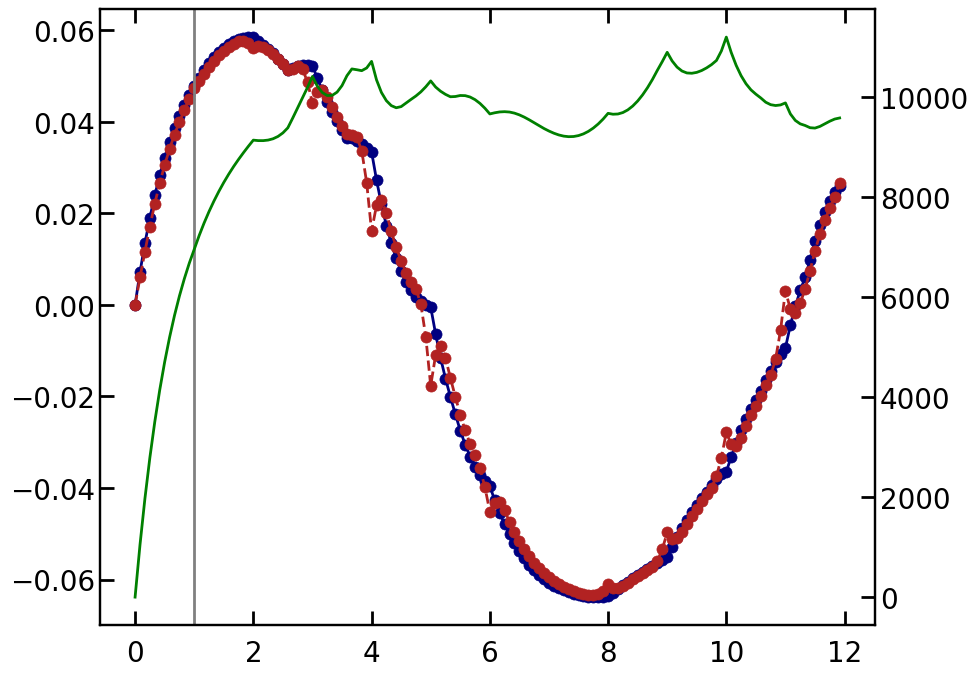

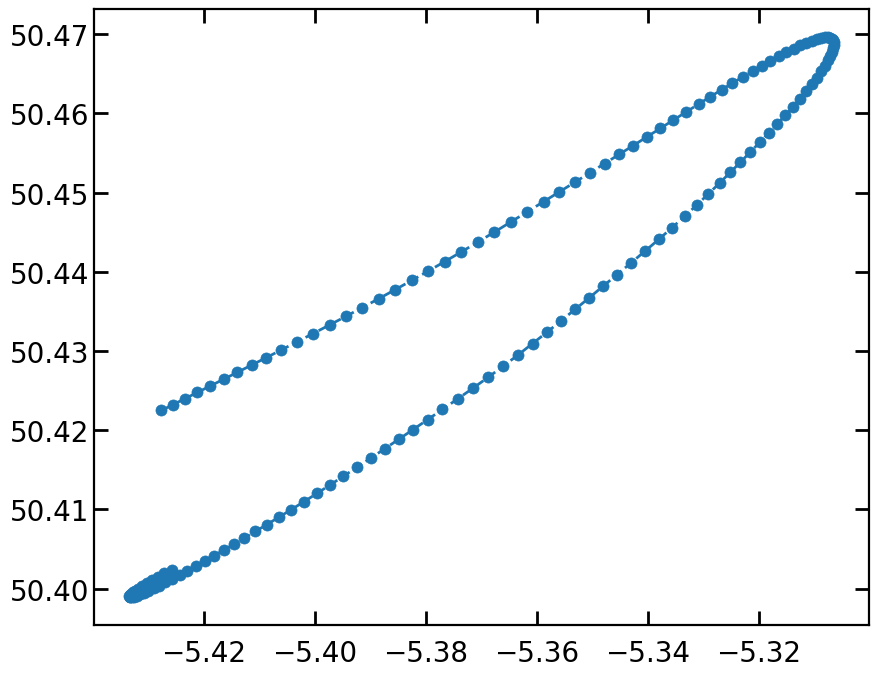

In [ ]:
id = 12 # 22#8049
fig, ax = plt.subplots()
ax.plot((ds_dt.time[id]-ds_dt.time[0,0])/sec_in_hour,ds_dt.uf[id],'-o',color='navy')
ax.plot((ds_Delta_t.time[id,]-ds_Delta_t.time[0,0])/sec_in_hour,ds_Delta_t.uf[id],'--o',color='firebrick')
axb = ax.twinx()
axb.plot((ds.time[id]-ds.time[0,0])/sec_in_hour, REPs[id],color='green')

fig2,ax2 =plt.subplots()#subplot_kw={'projection':ccrs.PlateCarree()})
# ax2.coastlines()
# ax2.add_feature(cart.feature.LAND, facecolor='lightgrey')
ax.axvline(1,color='grey')
ax2.plot(ds.lon[id],ds.lat[id],'--o')

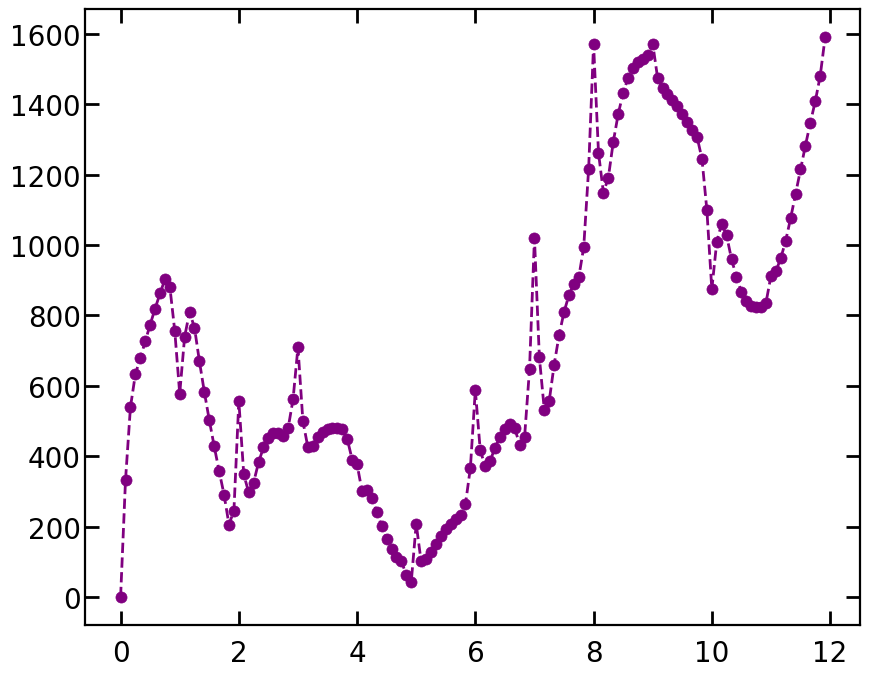

In [43]:

id = 1 # 22#8049
fig, ax = plt.subplots()
# ax.plot((ds_dt.time[id]-ds_dt.time[0,0])/sec_in_hour, REPs_dt[id],color='green')
ax.plot((ds_Delta_t.time[id]-ds_Delta_t.time[0,0])/sec_in_hour, REPs_Delta_t[id],'--o',color='purple')


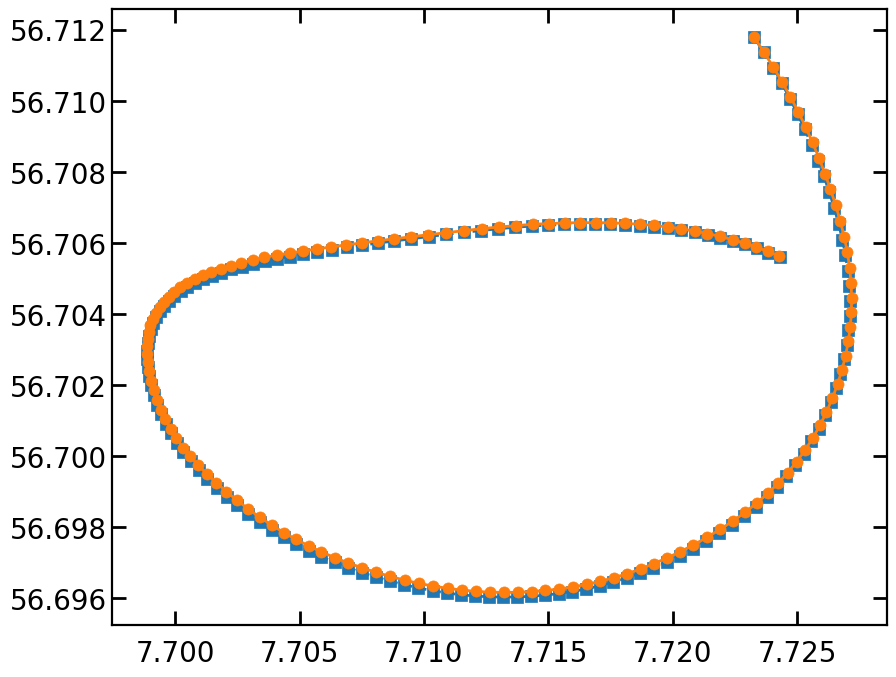

In [35]:
fig2,ax2 =plt.subplots()#subplot_kw={'projection':ccrs.PlateCarree()})
# ax2.coastlines()
# ax2.add_feature(cart.feature.LAND, facecolor='lightgrey')
id=15

ax2.plot(ds_Delta_t.lon[id],ds_Delta_t.lat[id],'--s')
ax2.plot(ds_dt.lon[id],ds_dt.lat[id],'-o')

In [ ]:
ds_dt.time[0,0].values
ds_Delta_t.time[0,0].values/min_in_hour

array(86400.)

In [210]:
# calculate kernels
dt = ds.time[0,1]-ds.time[0,0]
duslip_dt = dUslip_dt(ds.uf,dt)
dvslip_dt = dUslip_dt(ds.vf,dt)
ds.time[0]
tmin = dt
tmax = int(ds.time[0].max(skipna = True).values - dt)
tlist = np.arange(dt,tmax,dt)
nstart = int(tmin/dt)
nstop = int(tmax/dt)
Kbasset = Basset_kernel(tmax,np.flip(tlist),diameter,kinematic_viscosity_water)
Kdorgan = Mei1992_kernel(tmax,np.flip(tlist),cs['Dorgan']['c1'],cs['Dorgan']['c2'],diameter, kinematic_viscosity_water, mean.values)
Kmei = Mei1992_kernel(tmax,np.flip(tlist),cs['Mei']['c1'],cs['Mei']['c2'],diameter, kinematic_viscosity_water, mean.values)
Kkim = Mei1992_kernel(tmax,np.flip(tlist),cs['Kim']['c1'],cs['Kim']['c2'],diameter, kinematic_viscosity_water, mean.values)


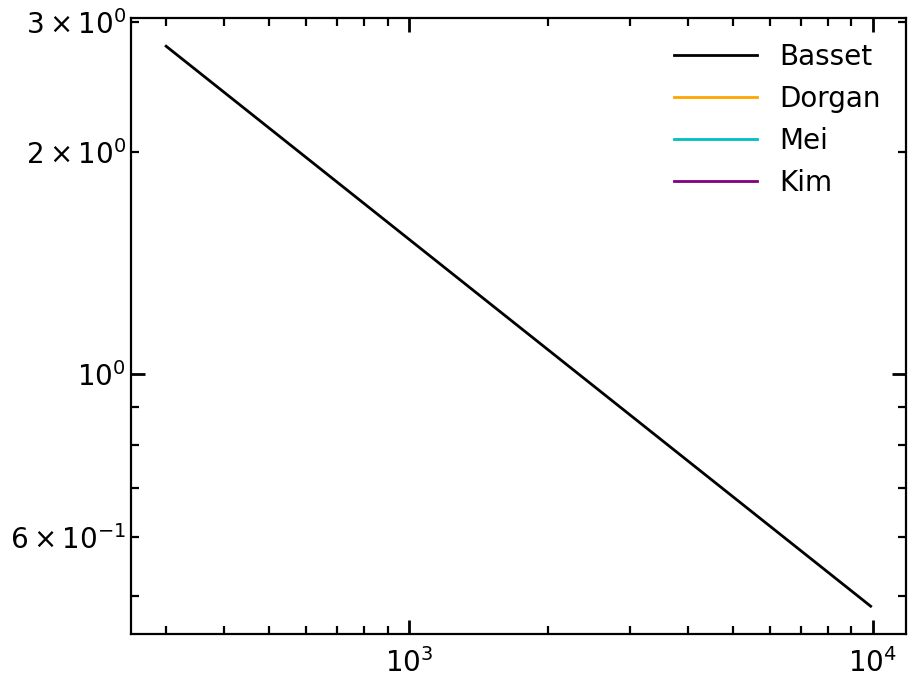

In [211]:
fig,ax=plt.subplots()
ax.plot(tmax-np.flip(tlist),Kbasset,color='k')
ax.plot(tmax-np.flip(tlist),Kdorgan,color='orange')
ax.plot(tmax-np.flip(tlist),Kmei,color='c')
ax.plot(tmax-np.flip(tlist),Kkim,color='purple')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(['Basset','Dorgan','Mei','Kim'])

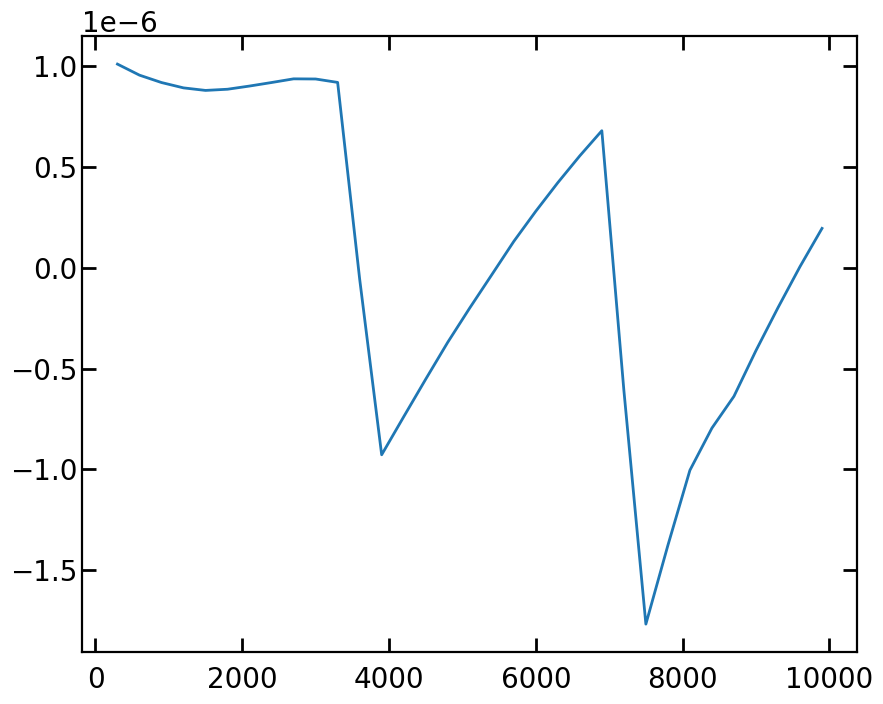

In [212]:
fig,ax=plt.subplots()
ax.plot(tlist[0:],duslip_dt[0,1:nstop])

In [140]:
1/tau_p * np.sum(duslip_dt[0,nstart+5:nstop]*(Kbasset)[5:]*dt).values


8.868419075503973e-08

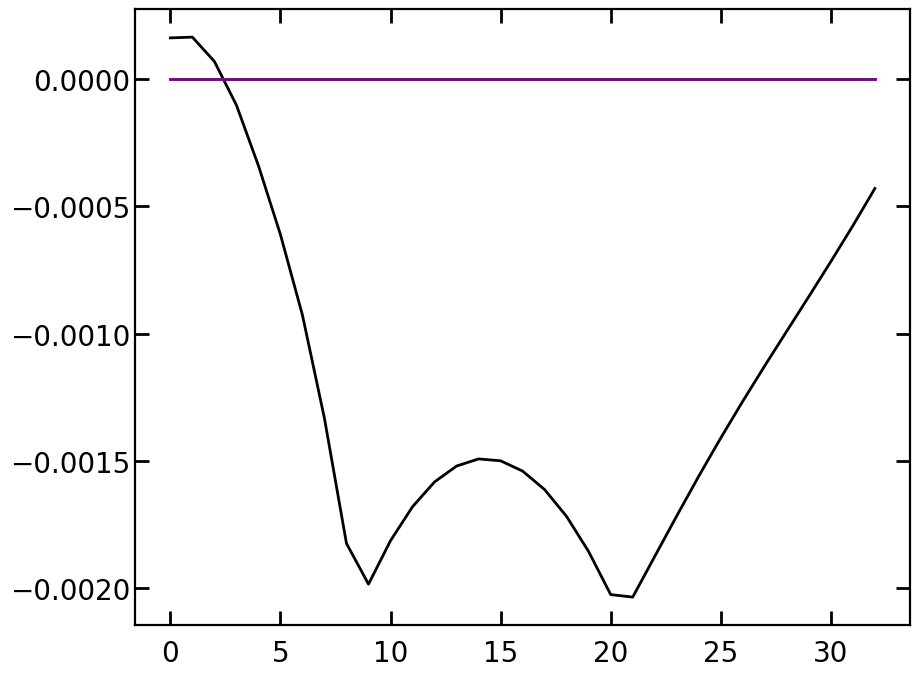

In [213]:
basset_history_term = np.cumsum(np.flip(duslip_dt[0,nstart:nstop])*(Kbasset)*dt)
dorgan_history_term = np.cumsum(np.flip(duslip_dt[0,nstart:nstop])*(Kdorgan)*dt)
mei_history_term = np.cumsum(np.flip(duslip_dt[0,nstart:nstop])*(Kmei)*dt)
kim_history_term = np.cumsum(np.flip(duslip_dt[0,nstart:nstop])*(Kkim)*dt)
fig,ax=plt.subplots()
ax.plot(basset_history_term,color='k')
ax.plot(dorgan_history_term,color='orange')
ax.plot(mei_history_term,color='c')
ax.plot(kim_history_term,color='purple')

In [213]:
(1/3 * 0.1*0.1/ (kinematic_viscosity_water) ) / (12*3600)

0.05620129585850627